SERVQUAL Dataset Creation Notebook
Purpose: Extract high-quality reviews from database for manual SERVQUAL labeling
Target: 800 reviews across 5 e-commerce apps
Quality focus: Length, rating distribution, content meaningful# SERVQUAL Dataset Creation Notebook


In [12]:
import sys
import os
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Add project root to path
sys.path.append('C:/Users/User/Desktop/ABSA project')

from src.data.storage import storage
from src.utils.config import config

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✅ Imports complete")
print(f"📊 Target dataset size: 800 reviews")
print(f"🎯 Purpose: SERVQUAL model training data")

✅ Imports complete
📊 Target dataset size: 800 reviews
🎯 Purpose: SERVQUAL model training data


In [13]:
# Test database connection
health_status = storage.health_check()
print("🔍 Storage Health Check:")
for component, status in health_status.items():
    print(f"  {component}: {status}")

if health_status['overall'] != 'healthy':
    raise Exception("❌ Database connection issues. Please check PostgreSQL service.")

print("\n✅ Database connection successful")

🔍 Storage Health Check:
  database: healthy
  redis: healthy
  overall: healthy

✅ Database connection successful


In [15]:
# Get overview of current review data
query_overview = """
SELECT 
    app_id,
    COUNT(*) as total_reviews,
    AVG(rating) as avg_rating,
    MIN(content_length) as min_length,
    MAX(content_length) as max_length,
    AVG(content_length) as avg_length,
    COUNT(*) FILTER (WHERE processed = TRUE) as processed_reviews,
    MIN(review_date) as oldest_review,
    MAX(review_date) as newest_review
FROM reviews 
WHERE is_spam = FALSE
GROUP BY app_id
ORDER BY total_reviews DESC
"""

overview_df = storage.db.execute_query(query_overview)
print("📊 Current Database Overview:")
print(overview_df.to_string(index=False))

# Get app names for better display
apps_query = "SELECT app_id, app_name FROM apps"
apps_df = storage.db.execute_query(apps_query)
app_names = dict(zip(apps_df['app_id'], apps_df['app_name']))

# Add app names to overview
overview_df['app_name'] = overview_df['app_id'].map(app_names)
print(f"\n📈 Total reviews available: {overview_df['total_reviews'].sum():,}")

📊 Current Database Overview:
                           app_id  total_reviews         avg_rating  min_length  max_length           avg_length  processed_reviews oldest_review newest_review
                  com.ebay.mobile           3412 3.8906799531066823           5         500  82.9106096131301290               1304    2025-05-13    2025-06-17
com.amazon.mShop.android.shopping           1882 2.9516471838469713           5         500 124.0632306057385760               1260    2025-05-23    2025-06-17
                 com.etsy.android           1379 4.3618564176939811           5         500  79.8107324147933285                773    2025-05-18    2025-06-17
                        com.zzkko           1294 2.6653786707882535           5         500 128.0950540958268934                723    2025-05-19    2025-06-17
             com.einnovation.temu           1093 4.0558096980786825           5         500  79.9313815187557182               1093    2025-06-09    2025-06-17

📈 Total re

In [16]:
# Define quality filtering criteria for SERVQUAL dataset
QUALITY_CRITERIA = {
    'min_length': 50,          # Minimum characters for meaningful content
    'max_length': 500,         # Maximum to avoid very long reviews
    'exclude_ratings': [],     # Don't exclude any ratings (need full spectrum)
    'min_date': '2024-01-01',  # Recent reviews only
    'target_per_app': 160      # 800 / 5 apps = 160 per app
}

print("🎯 Quality Filtering Criteria:")
for key, value in QUALITY_CRITERIA.items():
    print(f"  {key}: {value}")

# Additional text quality filters
def has_meaningful_content(text):
    """Check if review has meaningful content beyond basic words."""
    if not text or len(text.strip()) < QUALITY_CRITERIA['min_length']:
        return False
    
    # Check for actual words (not just punctuation/numbers)
    word_count = len(re.findall(r'\b[a-zA-Z]+\b', text))
    if word_count < 8:  # At least 8 actual words
        return False
    
    # Avoid extremely repetitive content
    words = text.lower().split()
    if len(set(words)) < len(words) * 0.5:  # At least 50% unique words
        return False
        
    return True

print("\n✅ Quality criteria defined")

🎯 Quality Filtering Criteria:
  min_length: 50
  max_length: 500
  exclude_ratings: []
  min_date: 2024-01-01
  target_per_app: 160

✅ Quality criteria defined


In [19]:
# Query to get high-quality reviews for each app
quality_reviews_query = """
SELECT 
    review_id,
    app_id,
    content,
    rating,
    content_length,
    review_date,
    user_name
FROM reviews 
WHERE 
    app_id = :app_id
    AND is_spam = FALSE
    AND content_length BETWEEN :min_length AND :max_length
    AND review_date >= :min_date
    AND content IS NOT NULL
    AND TRIM(content) != ''
ORDER BY 
    CASE 
        -- Prefer balanced rating distribution
        WHEN rating IN (2, 3, 4) THEN 1
        WHEN rating IN (1, 5) THEN 2
    END,
    content_length DESC,
    review_date DESC
LIMIT :limit_count
"""

print("🔍 Extracting high-quality reviews by app...")

all_quality_reviews = []
app_stats = {}

for _, row in overview_df.iterrows():
    app_id = row['app_id']
    app_name = row['app_name']
    
    print(f"\n📱 Processing {app_name} ({app_id})...")
    
    # Execute query for this app - FIXED PARAMETERS
    params = {
        'app_id': app_id,
        'min_length': QUALITY_CRITERIA['min_length'],
        'max_length': QUALITY_CRITERIA['max_length'], 
        'min_date': QUALITY_CRITERIA['min_date'],
        'limit_count': QUALITY_CRITERIA['target_per_app'] * 2
    }
    
    app_reviews_df = storage.db.execute_query(quality_reviews_query, params)
    
    # Apply additional quality filtering
    quality_mask = app_reviews_df['content'].apply(has_meaningful_content)
    filtered_reviews = app_reviews_df[quality_mask].copy()
    
    # Take target number per app
    selected_reviews = filtered_reviews.head(QUALITY_CRITERIA['target_per_app']).copy()
    
    # Add app name for reference - FIXED PANDAS WARNING
    selected_reviews.loc[:, 'app_name'] = app_name
    
    all_quality_reviews.append(selected_reviews)
    
    # Track stats
    app_stats[app_name] = {
        'total_available': len(app_reviews_df),
        'after_quality_filter': len(filtered_reviews),
        'selected': len(selected_reviews),
        'avg_length': selected_reviews['content_length'].mean() if len(selected_reviews) > 0 else 0,
        'rating_distribution': selected_reviews['rating'].value_counts().to_dict() if len(selected_reviews) > 0 else {}
    }
    
    print(f"  ✅ Selected {len(selected_reviews)} reviews")
    if len(selected_reviews) > 0:
        print(f"     Average length: {selected_reviews['content_length'].mean():.0f} chars")
        print(f"     Rating distribution: {dict(selected_reviews['rating'].value_counts().sort_index())}")

# Combine all apps
final_dataset = pd.concat(all_quality_reviews, ignore_index=True) if all_quality_reviews else pd.DataFrame()
print(f"\n🎯 Final dataset size: {len(final_dataset)} reviews")

🔍 Extracting high-quality reviews by app...

📱 Processing eBay online shopping & selling (com.ebay.mobile)...
  ✅ Selected 160 reviews
     Average length: 244 chars
     Rating distribution: {2: 73, 3: 41, 4: 46}

📱 Processing Amazon Shopping (com.amazon.mShop.android.shopping)...
  ✅ Selected 160 reviews
     Average length: 285 chars
     Rating distribution: {2: 84, 3: 53, 4: 23}

📱 Processing Etsy: A Special Marketplace (com.etsy.android)...
  ✅ Selected 160 reviews
     Average length: 242 chars
     Rating distribution: {1: 42, 2: 21, 3: 36, 4: 43, 5: 18}

📱 Processing SHEIN-Shopping Online (com.zzkko)...
  ✅ Selected 160 reviews
     Average length: 217 chars
     Rating distribution: {1: 2, 2: 74, 3: 45, 4: 39}

📱 Processing Temu: Shop Like a Billionaire (com.einnovation.temu)...
  ✅ Selected 160 reviews
     Average length: 244 chars
     Rating distribution: {1: 26, 2: 24, 3: 32, 4: 54, 5: 24}

🎯 Final dataset size: 800 reviews


In [20]:
print("📊 Final Dataset Analysis:")
print(f"Total reviews: {len(final_dataset)}")
print(f"Average content length: {final_dataset['content_length'].mean():.1f} chars")
print(f"Length range: {final_dataset['content_length'].min()} - {final_dataset['content_length'].max()}")

# Rating distribution
print("\n📈 Rating Distribution:")
rating_dist = final_dataset['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(final_dataset)) * 100
    print(f"  {rating} stars: {count:3d} ({percentage:4.1f}%)")

# App distribution
print("\n🏪 App Distribution:")
app_dist = final_dataset['app_name'].value_counts()
for app, count in app_dist.items():
    percentage = (count / len(final_dataset)) * 100
    print(f"  {app}: {count:3d} ({percentage:4.1f}%)")

# Content length distribution
print(f"\n📏 Content Length Statistics:")
print(f"  Min: {final_dataset['content_length'].min()} chars")
print(f"  Max: {final_dataset['content_length'].max()} chars") 
print(f"  Mean: {final_dataset['content_length'].mean():.1f} chars")
print(f"  Median: {final_dataset['content_length'].median():.1f} chars")

📊 Final Dataset Analysis:
Total reviews: 800
Average content length: 246.5 chars
Length range: 50 - 500

📈 Rating Distribution:
  1 stars:  70 ( 8.8%)
  2 stars: 276 (34.5%)
  3 stars: 207 (25.9%)
  4 stars: 205 (25.6%)
  5 stars:  42 ( 5.2%)

🏪 App Distribution:
  eBay online shopping & selling: 160 (20.0%)
  Amazon Shopping: 160 (20.0%)
  Etsy: A Special Marketplace: 160 (20.0%)
  SHEIN-Shopping Online: 160 (20.0%)
  Temu: Shop Like a Billionaire: 160 (20.0%)

📏 Content Length Statistics:
  Min: 50 chars
  Max: 500 chars
  Mean: 246.5 chars
  Median: 220.0 chars


In [21]:
print("📝 Sample Review Examples (for quality verification):")
print("=" * 80)

# Show 2 examples from each app
for app_name in final_dataset['app_name'].unique():
    app_reviews = final_dataset[final_dataset['app_name'] == app_name]
    sample_reviews = app_reviews.sample(n=min(2, len(app_reviews)), random_state=42)
    
    print(f"\n🏪 {app_name}:")
    for _, review in sample_reviews.iterrows():
        print(f"  Rating: {review['rating']} | Length: {review['content_length']} chars")
        print(f"  Content: {review['content'][:150]}...")
        print()

📝 Sample Review Examples (for quality verification):

🏪 eBay online shopping & selling:
  Rating: 4 | Length: 158 chars
  Content: good most of the time could do with a better search engine line QR code reader for car parts as most car electronic sensors have a QR code on them the...

  Rating: 3 | Length: 156 chars
  Content: The eBay app is ok. It works at least. However it is missing one main feature. I can't access the business hub unless I search for it under the help o...


🏪 Amazon Shopping:
  Rating: 4 | Length: 214 chars
  Content: It seems like all my past orders have been deleted. It shows that I have ordered nothing at all. Why is that? I ordered quite a few things in 2024. Th...

  Rating: 2 | Length: 208 chars
  Content: Keeps randomly scrolling up by itself when I'm scrolling down reading through reviews. Very annoying and hard to find where I was reading before it ha...


🏪 Etsy: A Special Marketplace:
  Rating: 5 | Length: 497 chars
  Content: I am dissatisfied as I wa

In [24]:
# Prepare dataset for manual labeling
labeling_dataset = final_dataset[[
    'review_id', 'app_id', 'app_name', 'content', 'rating', 'review_date'
]].copy()

# Add empty SERVQUAL labels structure for manual completion
servqual_template = {
    "reliability": {"relevant": False, "sentiment": 0.0},
    "assurance": {"relevant": False, "sentiment": 0.0}, 
    "tangibles": {"relevant": False, "sentiment": 0.0},
    "empathy": {"relevant": False, "sentiment": 0.0},
    "responsiveness": {"relevant": False, "sentiment": 0.0}
}

# Convert to list of dictionaries for JSON export
labeling_records = []
for _, row in labeling_dataset.iterrows():
    record = {
        "review_id": str(row['review_id']),  # Convert UUID to string
        "app_id": str(row['app_id']),
        "app_name": str(row['app_name']),
        "content": str(row['content']),
        "rating": int(row['rating']),
        "review_date": row['review_date'].strftime('%Y-%m-%d') if pd.notnull(row['review_date']) else None,
        "content_length": len(row['content']),
        "servqual_labels": servqual_template.copy(),
        "labeling_status": "pending",
        "labeler_notes": ""
    }
    labeling_records.append(record)

print(f"📦 Prepared {len(labeling_records)} records for manual labeling")

📦 Prepared 800 records for manual labeling


In [25]:
# Custom JSON encoder to handle special data types
class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'isoformat'):
            return obj.isoformat()
        elif hasattr(obj, '__str__'):
            return str(obj)
        return super().default(obj)

# Create data/training directory if it doesn't exist
training_dir = "C:/Users/User/Desktop/ABSA project/data/training"
os.makedirs(training_dir, exist_ok=True)

# Export main labeling dataset
output_file = os.path.join(training_dir, "servqual_unlabeled_dataset.json")
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(labeling_records, f, indent=2, ensure_ascii=False, cls=CustomJSONEncoder)

print(f"✅ Exported unlabeled dataset: {output_file}")

# Export dataset statistics for reference
stats_file = os.path.join(training_dir, "dataset_creation_stats.json")
creation_stats = {
    "creation_date": datetime.now().isoformat(),
    "total_reviews": len(labeling_records),
    "quality_criteria": QUALITY_CRITERIA,
    "app_statistics": app_stats,
    "rating_distribution": rating_dist.to_dict(),
    "content_length_stats": {
        "min": int(final_dataset['content_length'].min()),
        "max": int(final_dataset['content_length'].max()),
        "mean": float(final_dataset['content_length'].mean()),
        "median": float(final_dataset['content_length'].median())
    }
}

with open(stats_file, 'w', encoding='utf-8') as f:
    json.dump(creation_stats, f, indent=2, cls=CustomJSONEncoder)

print(f"✅ Exported creation statistics: {stats_file}")

# Export CSV for easy viewing
csv_file = os.path.join(training_dir, "servqual_dataset_preview.csv")
preview_df = labeling_dataset.copy()
preview_df['content_preview'] = preview_df['content'].str[:100] + "..."
preview_df.to_csv(csv_file, index=False, encoding='utf-8')

print(f"✅ Exported CSV preview: {csv_file}")

✅ Exported unlabeled dataset: C:/Users/User/Desktop/ABSA project/data/training\servqual_unlabeled_dataset.json
✅ Exported creation statistics: C:/Users/User/Desktop/ABSA project/data/training\dataset_creation_stats.json
✅ Exported CSV preview: C:/Users/User/Desktop/ABSA project/data/training\servqual_dataset_preview.csv


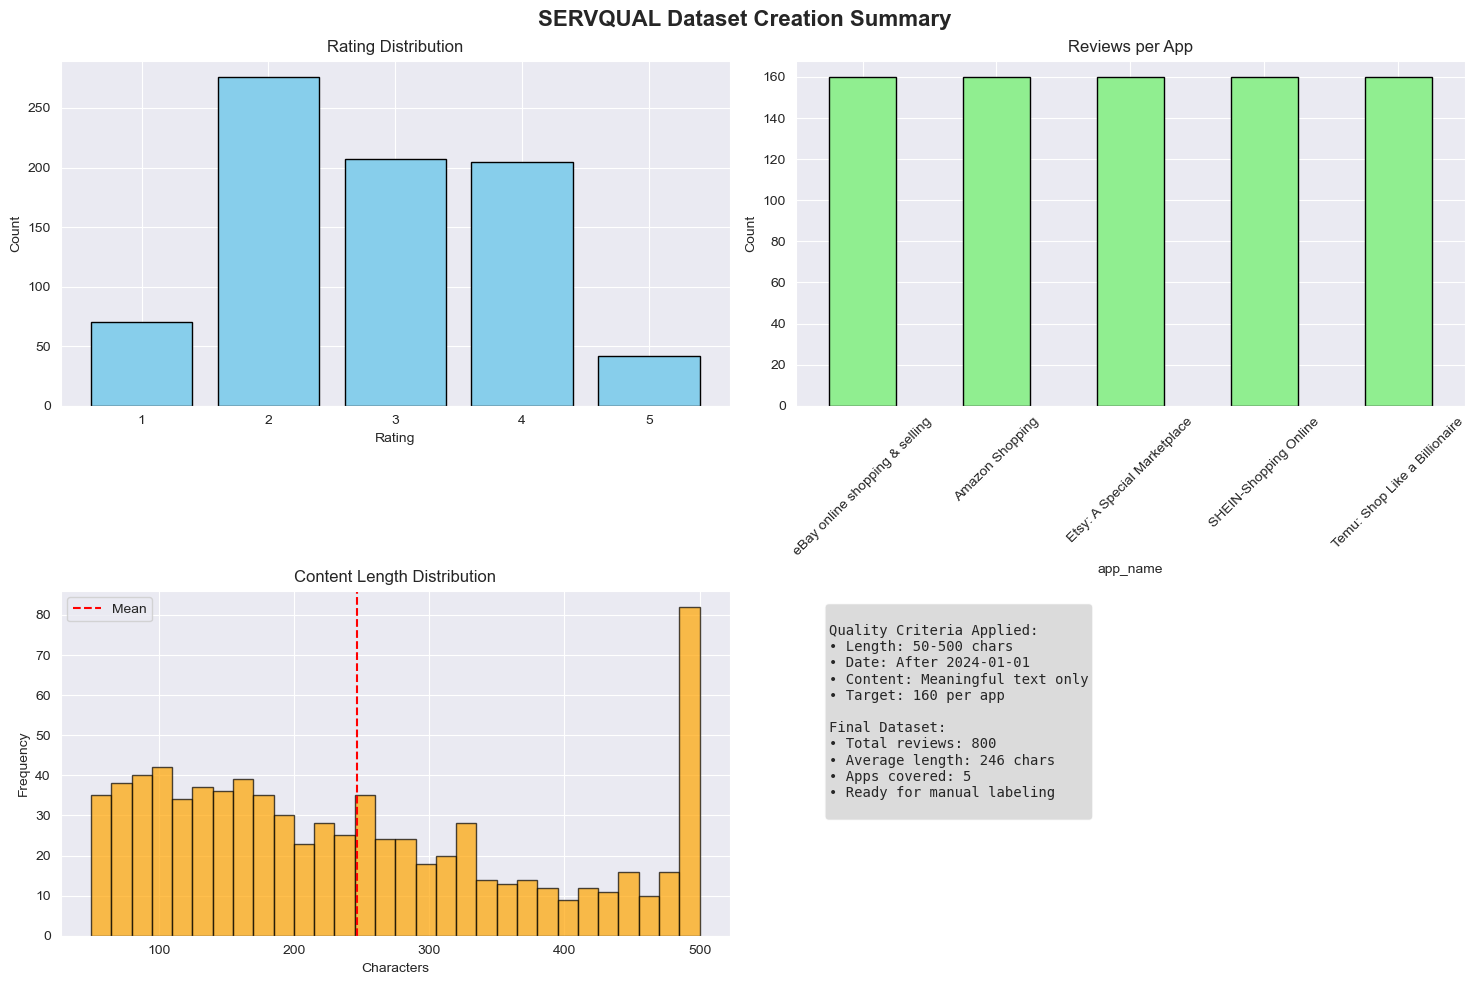


🎯 DATASET CREATION COMPLETE
✅ Created high-quality dataset with 800 reviews
📁 Files saved to: C:/Users/User/Desktop/ABSA project/data/training
📊 Ready for Phase 2: Manual SERVQUAL labeling
⏱️  Estimated labeling time: 8-10 hours


In [26]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SERVQUAL Dataset Creation Summary', fontsize=16, fontweight='bold')

# Rating distribution
axes[0, 0].bar(rating_dist.index, rating_dist.values, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(1, 6))

# App distribution
app_dist.plot(kind='bar', ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Reviews per App')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Content length distribution
axes[1, 0].hist(final_dataset['content_length'], bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Content Length Distribution')
axes[1, 0].set_xlabel('Characters')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(final_dataset['content_length'].mean(), color='red', linestyle='--', label='Mean')
axes[1, 0].legend()

# Quality criteria summary
criteria_text = f"""
Quality Criteria Applied:
• Length: {QUALITY_CRITERIA['min_length']}-{QUALITY_CRITERIA['max_length']} chars
• Date: After {QUALITY_CRITERIA['min_date']}
• Content: Meaningful text only
• Target: {QUALITY_CRITERIA['target_per_app']} per app

Final Dataset:
• Total reviews: {len(final_dataset)}
• Average length: {final_dataset['content_length'].mean():.0f} chars
• Apps covered: {len(final_dataset['app_name'].unique())}
• Ready for manual labeling
"""

axes[1, 1].text(0.05, 0.95, criteria_text, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(training_dir, 'dataset_creation_summary.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("🎯 DATASET CREATION COMPLETE")
print("="*80)
print(f"✅ Created high-quality dataset with {len(final_dataset)} reviews")
print(f"📁 Files saved to: {training_dir}")
print(f"📊 Ready for Phase 2: Manual SERVQUAL labeling")
print(f"⏱️  Estimated labeling time: 8-10 hours")
print("="*80)